# H12 signal detection

## Setup

In [3]:
import yaml
import pandas as pd
import malariagen_data
from pyprojroot import here
import numpy as np
import os
import dask
#dask.config.set(scheduler=dask_scheduler);
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run peak-utils.ipynb

In [ ]:
ag3 = malariagen_data.Ag3(pre = True)
sample_sets = ["1288-VO-UG-DONNELLY-VMF00168","1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "aim_species == 'gambiae' & sex_call == 'F'"
region = '2R'

In [ ]:
sample_sets = ["1288-VO-UG-DONNELLY-VMF00168","1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "aim_species == 'gambiae' & sex_call == 'F'"
region = '2L'
n_snps = 100000

pca_2L_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query)

Compute SNP allele counts:   0%|          | 0/9558 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/16362 [00:00<?, ?it/s]

In [11]:
standard = pca_2L_df.loc[pca_2L_df['PC1'] < -50, 'sample_id'].tolist()

In [23]:
inversion = pca_2L_df.loc[pca_2L_df['PC1'] > 50, 'sample_id'].tolist()

In [32]:
# Notebook parameters. Values here are for development only and 
# will be overridden when running via snakemake and papermill.
# cohort_id = 'CD-NU_Gbadolite_gamb_2015_Q3'
cohort_id = 'llineup'
#cohorts_analysis = "20230223"
contig = '2R'
#sample_query = f"sample_id in {inversion}"
sample_query = sample_query 
min_cohort_size = None
max_cohort_size = None
use_gcs_cache = False
dask_scheduler = "threads"
h12_signal_detection_min_delta_aic = 1000
h12_signal_detection_min_stat_max = 0.1
h12_signal_detection_gflanks = [6]

In [33]:
# load window sizes from output of h12-calibration

#calibration_dir = "./scripts_notebooks/haplotype_clustering/peak_centre"
#calibration_file_path = f"{calibration_dir}{cohort_id}.yaml"

calibration_file_path = f"{cohort_id}.yaml"
with open(calibration_file_path, 'r') as calibration_file:
    calibration_params = yaml.safe_load(calibration_file)
window_size = calibration_params["h12_window_size"]
window_size

1000

## Run signal detection

In [34]:
# set parameters for signal detection
filter_size = 20  # hampel filter parameter
filter_t = 2  # hampel filter parameter
scan_interval = 1  # step in cM
min_baseline = 0
max_baseline_percentile = 95
min_amplitude = 0.03
init_amplitude = 0.5
max_amplitude = 1.5
min_decay = 0.1
init_decay = 0.5 
max_abs_skew = 0.5
scan_start = None
scan_stop = None
# TODO maybe set false in production to avoid too many plots?
debug = True

In [35]:
# load gwss data
ppos, h12, x = ag3.h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis='gamb_colu', 
    sample_sets=sample_sets,
    sample_query=sample_query, 
    min_cohort_size=min_cohort_size,
    max_cohort_size=max_cohort_size,
)

Load haplotypes:   0%|          | 0/2484 [00:00<?, ?it/s]

In [23]:
h12

array([0.38453257, 0.1541515 , 0.00810392, ..., 0.07102616, 0.0612548 ,
       0.26634479])

In [36]:
# convert to int
ppos = ppos.astype(int)

In [37]:
# map physical to genetic position
gpos = ag_p2g(contig=contig, ppos=ppos)

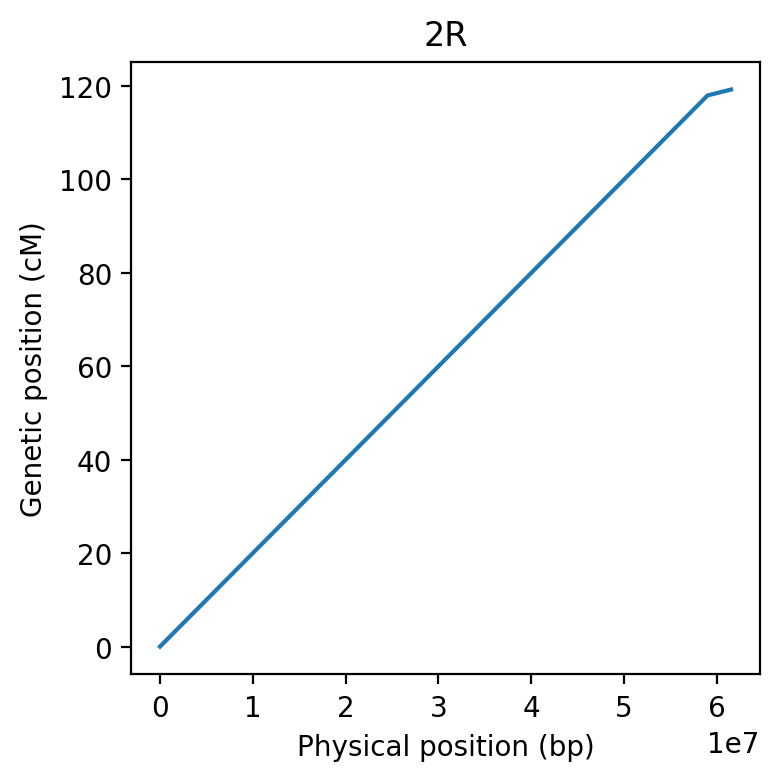

In [38]:
if debug:
    # quick check of genetic map
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ppos, gpos)
    ax.set_xlabel('Physical position (bp)')
    ax.set_ylabel('Genetic position (cM)')
    ax.set_title(contig)
    fig.tight_layout()


In [39]:
# filter outliers
h12_filtered = hampel_filter(h12, size=filter_size, t=filter_t)

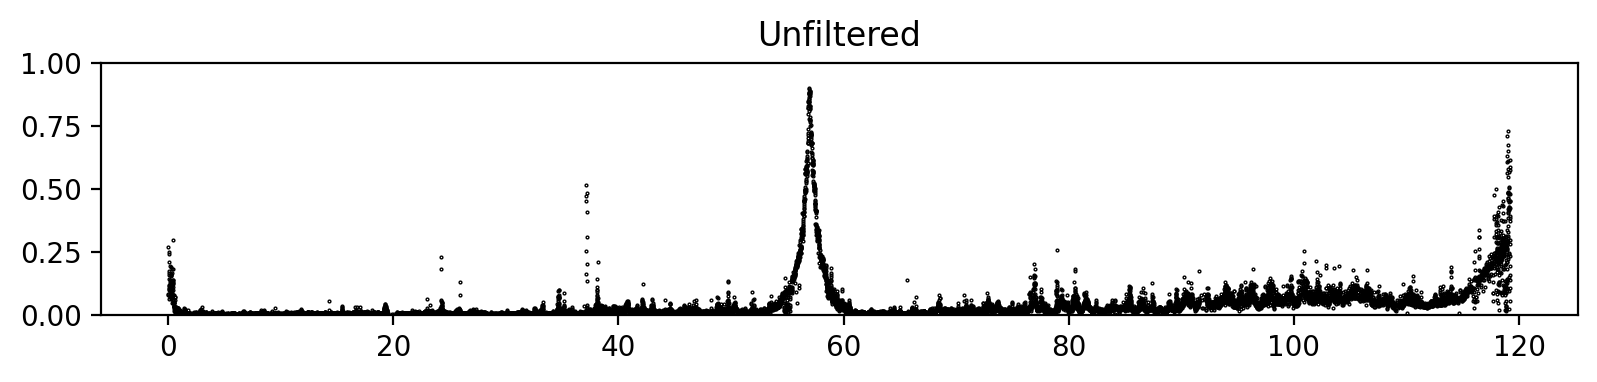

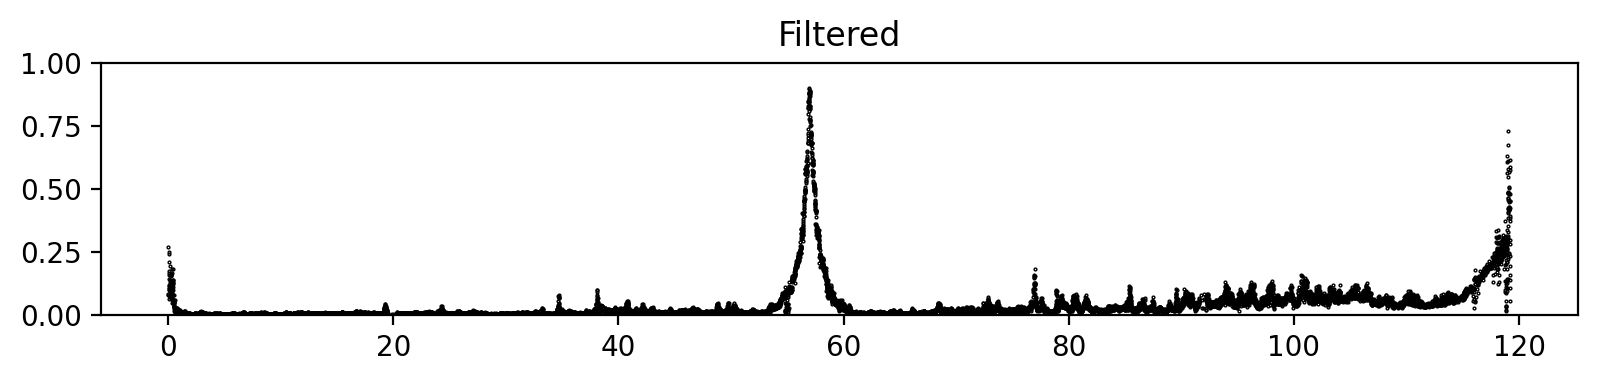

In [40]:
if debug:

    # before filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Unfiltered')
    ax.set_ylim(0, 1)
    fig.tight_layout()

    # after filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12_filtered, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Filtered')
    ax.set_ylim(0, 1)
    fig.tight_layout()


In [41]:
# set parameters
init_baseline = np.median(h12_filtered)
max_baseline = np.percentile(h12_filtered, max_baseline_percentile)
min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
if not scan_start:
    scan_start = 2
if not scan_stop:
    scan_stop = gpos[-1] - 2

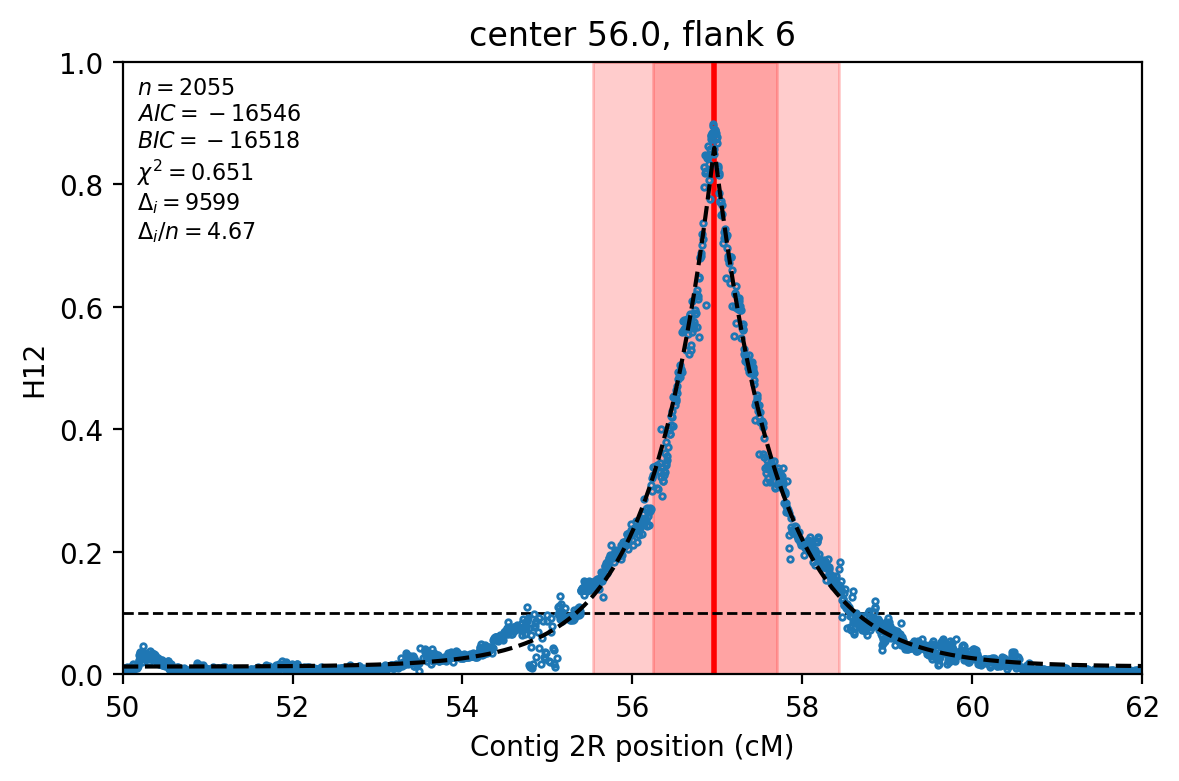

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 2055
    # variables        = 5
    chi-square         = 0.65148314
    reduced chi-square = 3.1780e-04
    Akaike info crit   = -16546.1792
    Bayesian info crit = -16518.0390
    R-squared          = 0.99067196
[[Variables]]
    center:     56.9626476 +/- 0.00191187 (0.00%) (init = 56)
    amplitude:  0.84788257 +/- 0.00223415 (0.26%) (init = 0.5)
    decay:      0.72558015 +/- 0.00327235 (0.45%) (init = 0.5)
    skew:      -0.02072544 +/- 0.00539254 (26.02%) (init = 0)
    baseline:   0.01282421 +/- 5.4706e-04 (4.27%) (init = 0.01204327)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = +0.7083
    C(amplitude, decay) = -0.5816
    C(decay, baseline)  = -0.5596


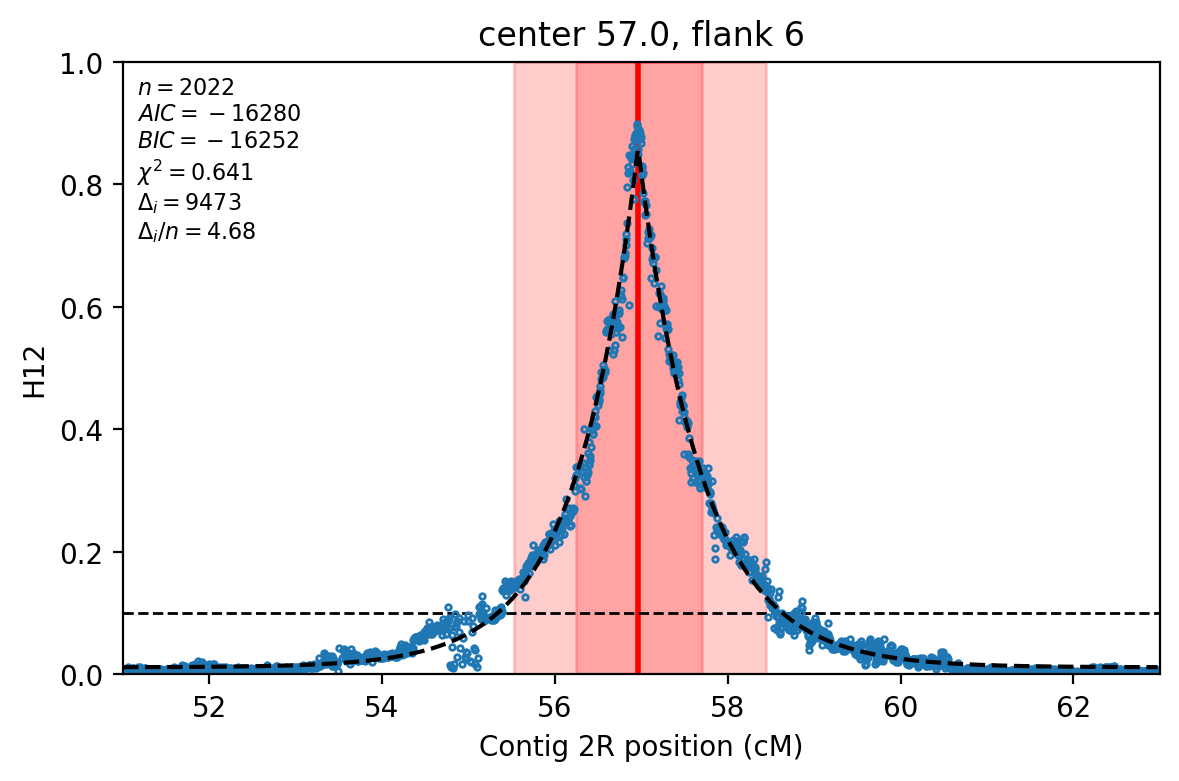

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2022
    # variables        = 5
    chi-square         = 0.64114558
    reduced chi-square = 3.1787e-04
    Akaike info crit   = -16279.9218
    Bayesian info crit = -16251.8626
    R-squared          = 0.99080258
[[Variables]]
    center:     56.9627656 +/- 0.00191772 (0.00%) (init = 57)
    amplitude:  0.84785343 +/- 0.00222807 (0.26%) (init = 0.5)
    decay:      0.72974211 +/- 0.00330891 (0.45%) (init = 0.5)
    skew:      -0.02020397 +/- 0.00537841 (26.62%) (init = 0)
    baseline:   0.01162305 +/- 5.5813e-04 (4.80%) (init = 0.01204327)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = +0.7083
    C(amplitude, decay) = -0.5774
    C(decay, baseline)  = -0.5692


,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,2R,56.962648,28481324,9598,0.898926,56.952918,28476459,56.926886,56.999452,...,0.847883,0.725580,-0.020725,0.715231,0.736079,0.012824,-16546.179190,-16518.039035,0.651483,-6947.608467
1,llineup,2R,56.962766,28481383,9472,0.898926,56.952918,28476459,56.926786,56.999767,...,0.847853,0.729742,-0.020204,0.719594,0.740034,0.011623,-16279.921765,-16251.862553,0.641146,-6807.101968


In [42]:
# set up results
results = []

# main loop, iterate along the genome
for gcenter in np.arange(scan_start, scan_stop, scan_interval):

    for gflank in h12_signal_detection_gflanks:

        # print('center', gcenter, 'flank size', gflank)

        result = fit_exponential_peak(
            ppos=ppos, 
            gpos=gpos, 
            stat_filtered=h12_filtered, 
            gcenter=gcenter, 
            gflank=gflank, 
            scan_interval=scan_interval,
            init_amplitude=init_amplitude,
            min_amplitude=min_amplitude,
            max_amplitude=max_amplitude,
            init_decay=init_decay,
            min_decay=min_decay,
            init_skew=init_skew,
            min_skew=min_skew,
            max_skew=max_skew,
            init_baseline=init_baseline,
            min_baseline=min_baseline,
            max_baseline=max_baseline,
            min_delta_aic=h12_signal_detection_min_delta_aic,
            min_stat_max=h12_signal_detection_min_stat_max,
            debug=debug,
        )

        if result is not None:
            results.append(result)

df_signals = pd.DataFrame.from_records(results)
df_signals

In [64]:
def dedup_signals(df_signals):
    
    keep = list(range(len(df_signals)))
    for i, this in df_signals.iterrows():
        for j, that in df_signals.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return df_signals.iloc[keep].copy()


In [65]:
df_signals_dedup = dedup_signals(df_signals)
df_signals_dedup

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
1,llineup,2L,2.015341,2852440,1780,0.883036,0.639037,1278075,1.893101,2.097011,...,0.888356,1.998329,0.290923,2.444801,1.633392,0.072972,-4416.691550,-4392.068488,13.090891,-2636.601026
2,llineup,2L,64.493803,34091671,8084,0.466132,64.502544,34096041,64.472495,64.512722,...,0.423548,0.401568,0.085757,0.426162,0.378393,0.011841,-18564.887747,-18536.933486,0.166893,-10480.312000


## Write outputs

In [ ]:
outdir= "./scripts_notebooks/haplotype_clustering/peak_centre"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir, f"{cohort_id}_{contig}.csv"), mode="w") as output_file:
    df_signals_dedup.to_csv(output_file, index=False)